## Data Loading and Preprocessing

In [1]:
import pyreadr
data_path = "../data/portarthur_sd_df_2019.rdata"
result = pyreadr.read_r(data_path)
df = result[list(result.keys())[0]]
df

,origin_census_block_group,device_count,destination_cbg,destination_device_count,year,uid,from_cnt,to_cnt
0,482450117002,98,482450111011,1,2019.0,100.0,48245,48245
1,482450117002,98,481990303003,1,2019.0,100.0,48245,48199
2,482450117002,98,482450003082,1,2019.0,100.0,48245,48245
3,482450117002,98,482450109022,1,2019.0,100.0,48245,48245
4,482450117002,98,482450003071,2,2019.0,100.0,48245,48245
...,...,...,...,...,...,...,...,...
5884172,482450109023,215,482450012002,5,2019.0,9.0,48245,48245
5884173,482450109023,215,482450063002,1,2019.0,9.0,48245,48245
5884174,482450109023,215,482450108001,6,2019.0,9.0,48245,48245
5884175,482450109023,215,482450109013,12,2019.0,9.0,48245,48245


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5884177 entries, 0 to 5884176
Data columns (total 8 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   origin_census_block_group  object 
 1   device_count               object 
 2   destination_cbg            object 
 3   destination_device_count   object 
 4   year                       float64
 5   uid                        float64
 6   from_cnt                   object 
 7   to_cnt                     object 
dtypes: float64(2), object(6)
memory usage: 359.1+ MB


Data Overview

The dataset contains **5.8 million** rows and **8 columns** tracking mobility patterns in Port Arthur.

Several numeric fields were stored as strings or floats:

```
device_count               object
destination_device_count   object
year                       float64
uid                        float64
```
Converted columns to appropriate types




In [3]:
df['device_count'] = df['device_count'].astype(int)
df['destination_device_count'] = df['destination_device_count'].astype(int)
df['year'] = df['year'].astype(int)
df['uid'] = df['uid'].astype(int)
df['origin_census_block_group'] = df['origin_census_block_group'].astype(str)
df['destination_cbg'] = df['destination_cbg'].astype(str)
df['from_cnt'] = df['from_cnt'].astype(str)
df['to_cnt'] = df['to_cnt'].astype(str)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5884177 entries, 0 to 5884176
Data columns (total 8 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   origin_census_block_group  object
 1   device_count               int64 
 2   destination_cbg            object
 3   destination_device_count   int64 
 4   year                       int64 
 5   uid                        int64 
 6   from_cnt                   object
 7   to_cnt                     object
dtypes: int64(4), object(4)
memory usage: 359.1+ MB


In [5]:
df.isnull().sum()

origin_census_block_group    0
device_count                 0
destination_cbg              0
destination_device_count     0
year                         0
uid                          0
from_cnt                     0
to_cnt                       0
dtype: int64

No missing values are present, hence we can say that all the columns are complete and ready for analysis.

In [6]:
from datetime import datetime, timedelta
df['date'] = df['uid'].apply(lambda x: datetime(2019, 1, 1) + timedelta(days=int(x) - 1))
df

,origin_census_block_group,device_count,destination_cbg,destination_device_count,year,uid,from_cnt,to_cnt,date
0,482450117002,98,482450111011,1,2019,100,48245,48245,2019-04-10
1,482450117002,98,481990303003,1,2019,100,48245,48199,2019-04-10
2,482450117002,98,482450003082,1,2019,100,48245,48245,2019-04-10
3,482450117002,98,482450109022,1,2019,100,48245,48245,2019-04-10
4,482450117002,98,482450003071,2,2019,100,48245,48245,2019-04-10
...,...,...,...,...,...,...,...,...,...
5884172,482450109023,215,482450012002,5,2019,9,48245,48245,2019-01-09
5884173,482450109023,215,482450063002,1,2019,9,48245,48245,2019-01-09
5884174,482450109023,215,482450108001,6,2019,9,48245,48245,2019-01-09
5884175,482450109023,215,482450109013,12,2019,9,48245,48245,2019-01-09


The uid field represents the day of the year starting from January 1, 2019. So converted it into a proper date. Now the dataset includes a `date` column in `YYYY-MM-DD` format for time-based analysis.

## Preparing Inflow Trends

In [7]:
inflow_df = (df.groupby(['date', 'destination_cbg'])['destination_device_count'].sum().reset_index().rename(columns={'destination_device_count': 'inflow'}))
inflow_df['smoothed_inflow'] = (inflow_df.groupby('destination_cbg')['inflow'].transform(lambda x: x.rolling(window=3, min_periods=1, center=True).mean()))
inflow_df['normalized_inflow'] = (inflow_df.groupby('destination_cbg')['smoothed_inflow'].transform(lambda x: (x - x.min()) / (x.max() - x.min())))

1. **Aggregated** total inflow per day and CBG
2. **Smoothed** the inflow using a 3-day centered rolling average
3. **Normalized** the smoothed inflow (Min-Max scaling) within each CBG


Now the data is ready for comparing inflo trends and using this we can create resilience index

## Functions

### Function to compute resilience

This function quantifies the resilience of a single Census Block Group (CBG) by analyzing its smoothed mobility patterns before, during, and after a disaster. It identifies key time points and calculates various resilience metrics based on concepts from both the papers provided

1.  **Baseline Definition:** The function first calculates a `baseline` activity level. This is the average `normalized_inflow` for the CBG before the diasaster
2.  **Disaster Onset ($t_0$):** The `t0` point is set to the `disaster_start` date.
3.  **Lowest Point ($t_D$):** The `tD` point is identified as the date when the `normalized_inflow` reaches its minimum value *after* $t_0$
4.  **Recovery Time ($t_1$):** The `t1` point represents the time of recovery or establishment of a "new normalcy". It's determined as the first date *after* $t_D$ where the `normalized_inflow` either recovers to or exceeds the `baseline`. If such a recovery is not observed by `recovery_end`, `t1` is set to `recovery_end`.
5.  **Temporal Order Validation:** A crucial check ensures that $t_0 \le t_D \le t_1$ to maintain the conceptual validity of the resilience triangle. If this order is violated, $t_1$ is adjusted to the `recovery_end`.
6.  **Functionality Loss (Area Under/Over the Curve):**
    * `area_loss`: This metric quantifies the cumulative deviation of the CBG's `normalized_inflow` from its `baseline` during the `[t0, t1]` period.
    * `area_baseline`: Represents the total ideal performance (baseline activity multiplied by the duration from $t_0$ to $t_1$).
7.  **Resilience Ratio:** Calculated as `1 - (area_loss / area_baseline)`. In this formulation, a **higher value indicates greater resilience**.
8.  **Vulnerability & Robustness:**
    * `vulnerability`: Defined as `(baseline - q_tD) / (tD - t0).days`. This measures the "depth" of the initial drop from the baseline to the lowest point ($t_D$).
    * `robustness`: Defined as `(baseline - q_tD) / (t1 - tD).days`. This measures the "depth" of recovery needed from the lowest point ($t_D$).

In [8]:
def compute_resilience_for_cbg(df_cbg, baseline_start, baseline_end, disaster_start, recovery_end):
    df_cbg = df_cbg.sort_values('date').copy()

    # Define baseline
    baseline_period = df_cbg[(df_cbg['date'] >= baseline_start) & (df_cbg['date'] <= baseline_end)]
    if baseline_period.empty:
        return None
    baseline = baseline_period['normalized_inflow'].mean()

    # Disaster onset
    t0 = disaster_start

    # Post-disaster data
    df_post = df_cbg[df_cbg['date'] >= t0]
    if df_post.empty:
        return None

    # tD = lowest point after disaster
    tD_row = df_post.loc[df_post['normalized_inflow'].idxmin()]
    tD = tD_row['date']
    min_val = tD_row['normalized_inflow']

    # t1 = recovery: first date after tD where inflow >= baseline
    df_after_tD = df_cbg[df_cbg['date'] > tD]
    recovery_rows = df_after_tD[df_after_tD['normalized_inflow'] >= baseline]
    t1 = recovery_rows['date'].min() if not recovery_rows.empty else df_cbg['date'].max()

    # Checking order
    if not (t0 <= tD <= t1):
        return None

    df_triangle = df_cbg[(df_cbg['date'] >= t0) & (df_cbg['date'] <= t1)].copy()
    df_triangle['baseline'] = baseline
    df_triangle['loss'] = baseline - df_triangle['normalized_inflow']
    df_triangle['loss'] = df_triangle['loss'].clip(lower=0)

    # Area under the loss curve
    area_loss = df_triangle['loss'].sum()

    # Full baseline area over this period
    days = (t1 - t0).days + 1
    area_baseline = baseline * days

    # Resilience Ratio
    resilience_ratio = 1 - (area_loss / area_baseline) if area_baseline > 0 else None

    # Vulnerability and Robustness
    vulnerability = (baseline - min_val) / max(1, (tD - t0).days)
    robustness = (baseline - min_val) / max(1, (t1 - tD).days)

    return {
        'cbg': df_cbg['destination_cbg'].iloc[0],
        'baseline': baseline,
        't0': t0,
        'tD': tD,
        't1': t1,
        'resilience_ratio': resilience_ratio,
        'vulnerability': vulnerability,
        'robustness': robustness,
        'area_loss': area_loss,
        'area_baseline': area_baseline
    }

### Function to visualize

This function visualizes the mobility patterns and resilience triangle for a given CBG.

* **Smoothed normalized inflow** over time
* **Baseline** inflow (pre-disaster average)
* **Area Loss** (red): Mobility below baseline
* **Area Gain** (blue): Mobility above baseline
* Key dates:

  * `t₀`: Disaster onset
  * `tD`: Maximum impact (lowest inflow)
  * `t₁`: Recovery point

This helps visually validate the computed resilience metrics.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_cbg_mobility(cbg_id, inflow_df, resilience_row):

    df_plot = inflow_df[inflow_df['destination_cbg'] == cbg_id].copy()
    baseline = resilience_row['baseline']
    t0 = resilience_row['t0']
    tD = resilience_row['tD']
    t1 = resilience_row['t1']

    df_plot = df_plot[df_plot['date'].between(t0 - timedelta(days=5), t1 + timedelta(days=5))].copy()
    df_plot['baseline'] = baseline

    # Define shaded area range
    mask = (df_plot['date'] >= t0) & (df_plot['date'] <= t1)
    shaded = df_plot[mask]

    plt.figure(figsize=(12, 5))

    # Smoothed inflow
    sns.lineplot(data=df_plot, x='date', y='normalized_inflow', label='Smoothed Inflow', color='blue')

    # Baseline line
    plt.axhline(baseline, color='gray', linestyle='--', label='Baseline')

    # Fill area loss (below baseline)
    plt.fill_between(
        shaded['date'],
        shaded['normalized_inflow'],
        baseline,
        where=(shaded['normalized_inflow'] < baseline),
        interpolate=True,
        color='red',
        alpha=0.3,
        label='Area Loss'
    )

    # Fill area gain (above baseline)
    plt.fill_between(
        shaded['date'],
        shaded['normalized_inflow'],
        baseline,
        where=(shaded['normalized_inflow'] > baseline),
        interpolate=True,
        color='lightblue',
        alpha=0.3,
        label='Area Gain'
    )

    # Vertical lines
    plt.axvline(t0, color='orange', linestyle='--', label='t₀: Disaster Start')
    plt.axvline(tD, color='red', linestyle='--', label='tD: Max Impact')
    plt.axvline(t1, color='green', linestyle='--', label='t₁: Recovery')

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    plt.title(f"CBG: {cbg_id} | Resilience Ratio: {resilience_row['resilience_ratio']:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Normalized Inflow')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_visits(df, start_date='2019-09-01', end_date='2019-09-30', impact_window=('2019-09-17', '2019-09-19')):
    # Ensure dates are datetime
    df['date'] = pd.to_datetime(df['date'])
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Define visit types
    df['visit_type'] = df.apply(
        lambda row: 'own' if row['origin_census_block_group'] == row['destination_cbg']
        else 'inward' if row['origin_census_block_group'][:5] != row['destination_cbg'][:5]
        else 'outward',
        axis=1
    )

    # Aggregate
    visit_counts = df.groupby(['date', 'visit_type'])['destination_device_count'].sum().reset_index()
    visit_pivot = visit_counts.pivot(index='date', columns='visit_type', values='destination_device_count').fillna(0)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=visit_pivot, linewidth=2.5)

    # Add shaded impact window
    plt.axvspan(pd.to_datetime(impact_window[0]), pd.to_datetime(impact_window[1]), color='gray', alpha=0.3, label='Imelda Impact Window')

    plt.title("Time Series of Visits in Port Arthur")
    plt.xlabel("Date")
    plt.ylabel("Number of Visits")
    plt.legend(title='Visit Type')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



## Disaster 1 Imelda


The dates for Imelda are available. 17th September to 19th September

In [11]:
import pandas as pd
disaster_start = pd.to_datetime("2019-09-17")
disaster_end = pd.to_datetime("2019-09-19")
baseline_start = pd.to_datetime("2019-09-01")
baseline_end = disaster_start - pd.Timedelta(days=1)
recovery_end = pd.to_datetime("2019-09-30")

In [12]:
analysis_window_df = inflow_df[
    (inflow_df['date'] >= baseline_start) &
    (inflow_df['date'] <= recovery_end)
]

resilience_results = []
cbgs = analysis_window_df['destination_cbg'].unique()

for cbg in cbgs:
    df_cbg = analysis_window_df[analysis_window_df['destination_cbg'] == cbg]
    result = compute_resilience_for_cbg(
        df_cbg,
        baseline_start=baseline_start,
        baseline_end=baseline_end,
        disaster_start=disaster_start,
        recovery_end=recovery_end
    )
    if result:
        resilience_results.append(result)

resilience_df = pd.DataFrame(resilience_results)

In [13]:
top_cbgs = resilience_df.sort_values(by='resilience_ratio', ascending=False).head(3)['cbg'].tolist()
bottom_cbgs = resilience_df.sort_values(by='resilience_ratio', ascending=True).head(3)['cbg'].tolist()

3 Least Resilient CBGs


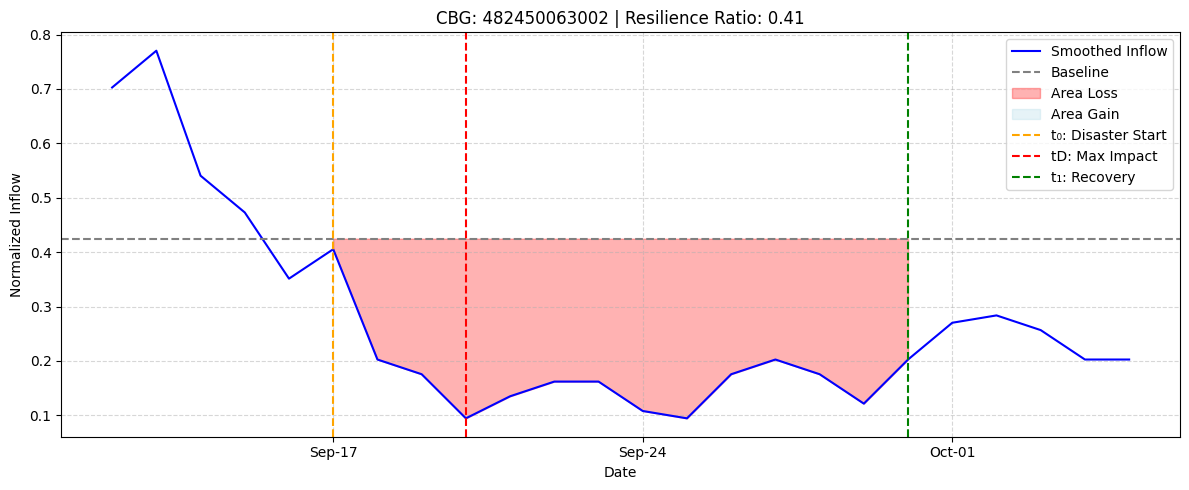

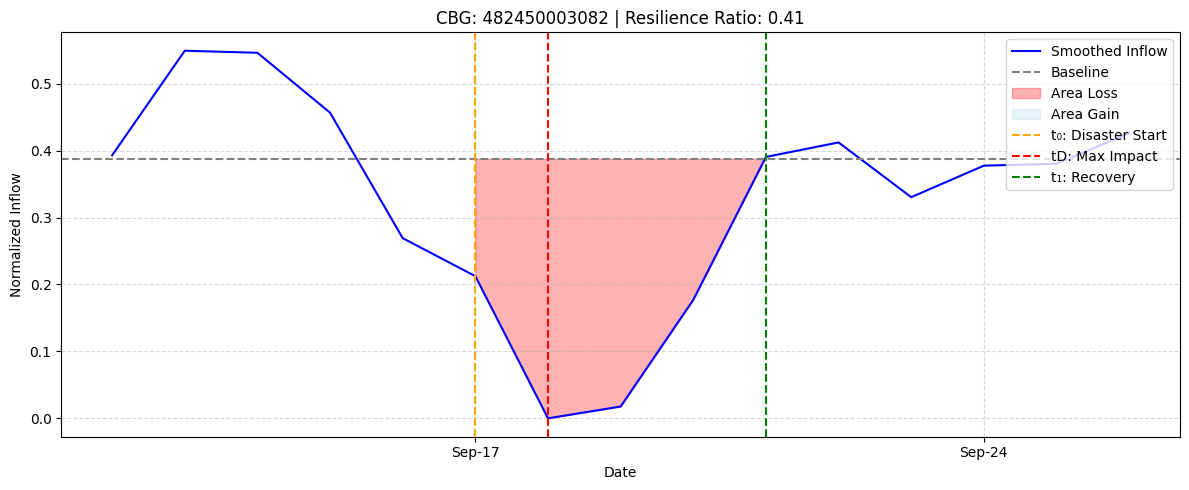

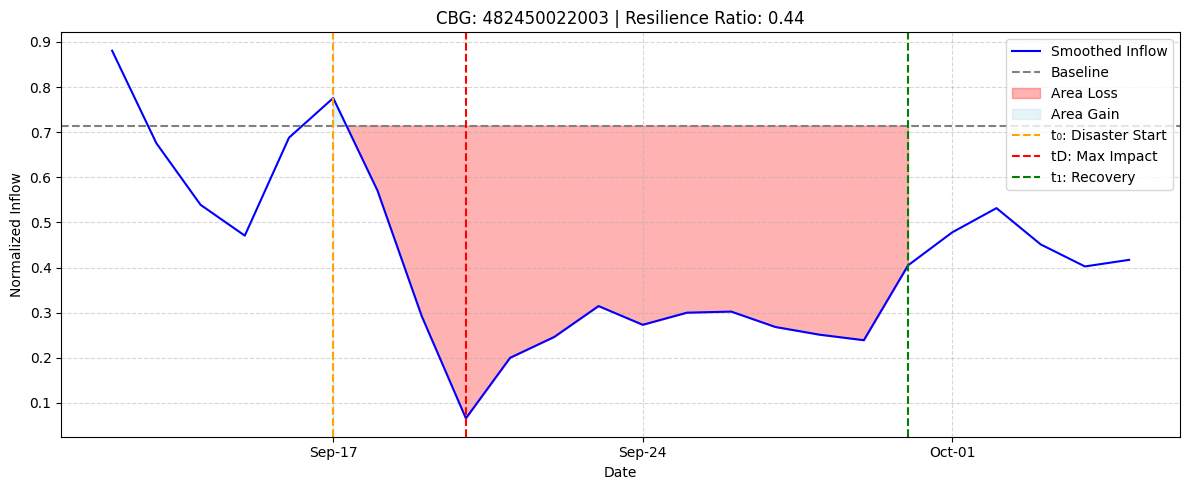

3 Most Resilient CBGs


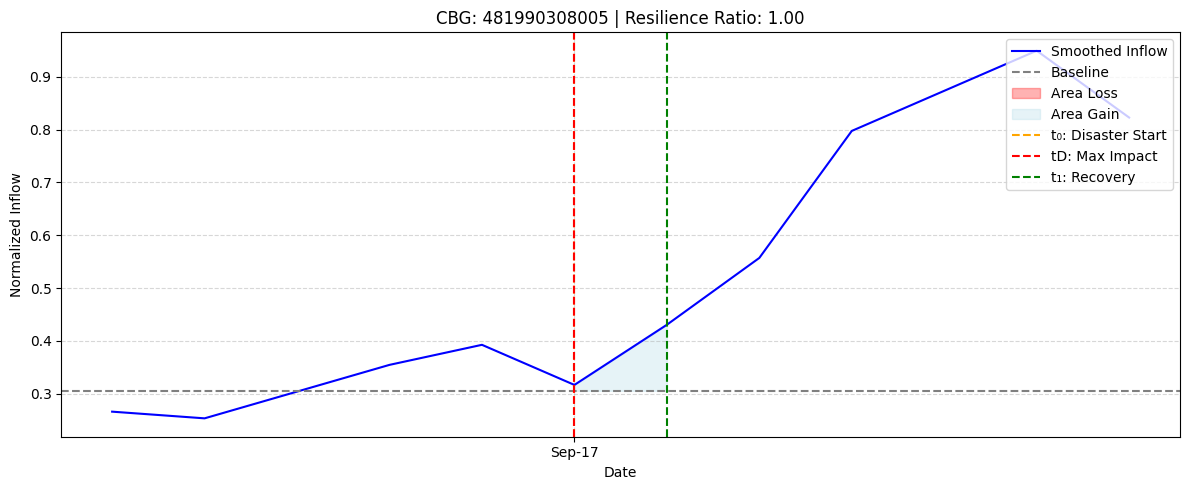

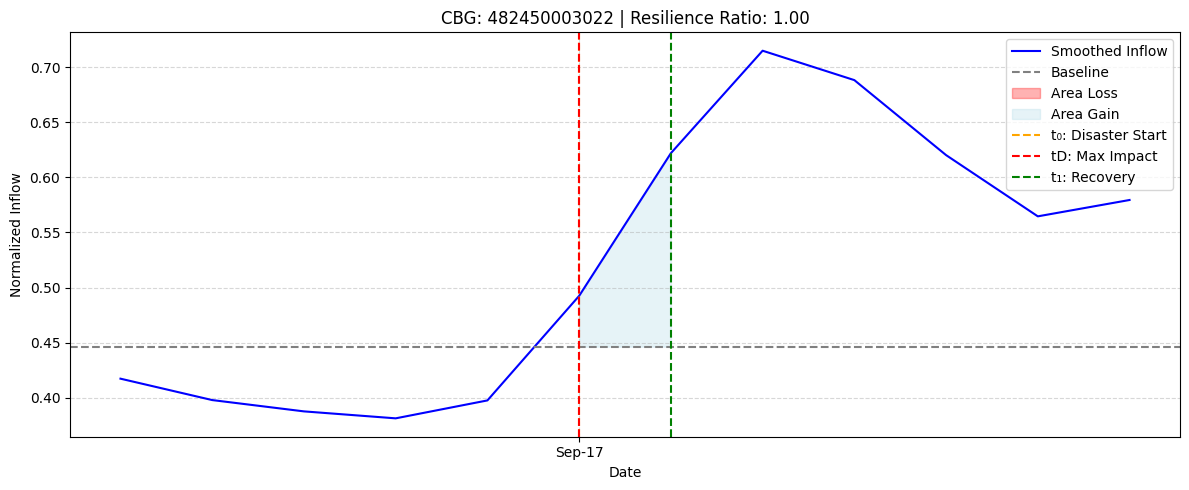

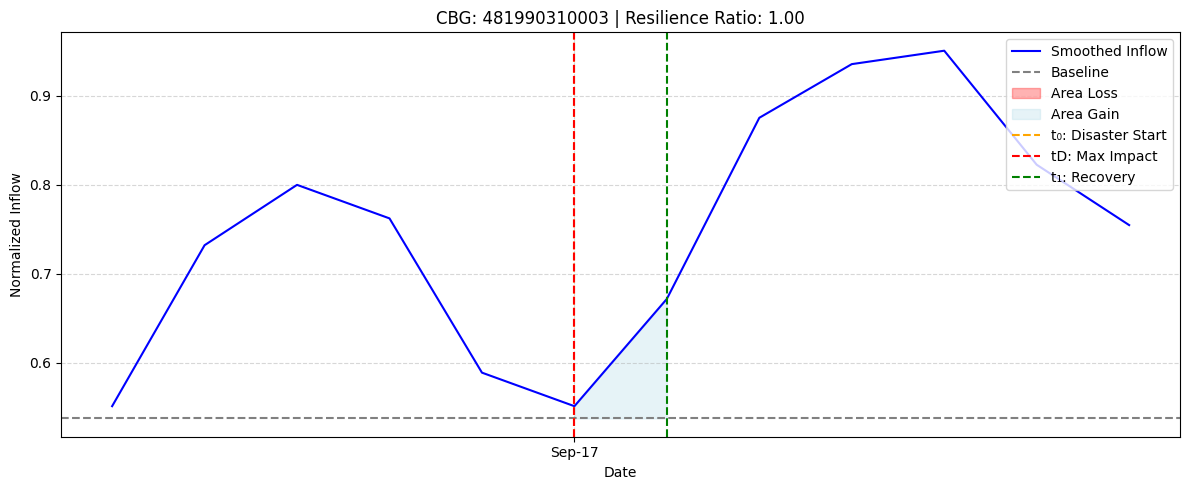

In [14]:
print("3 Least Resilient CBGs")
for cbg in bottom_cbgs:
    row = resilience_df[resilience_df['cbg'] == cbg].iloc[0]
    plot_cbg_mobility(cbg, inflow_df, row)


print("3 Most Resilient CBGs")
for cbg in top_cbgs:
    row = resilience_df[resilience_df['cbg'] == cbg].iloc[0]
    plot_cbg_mobility(cbg, inflow_df, row)

C:\Users\shiva\AppData\Local\Temp\ipykernel_9164\697898861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['visit_type'] = df.apply(


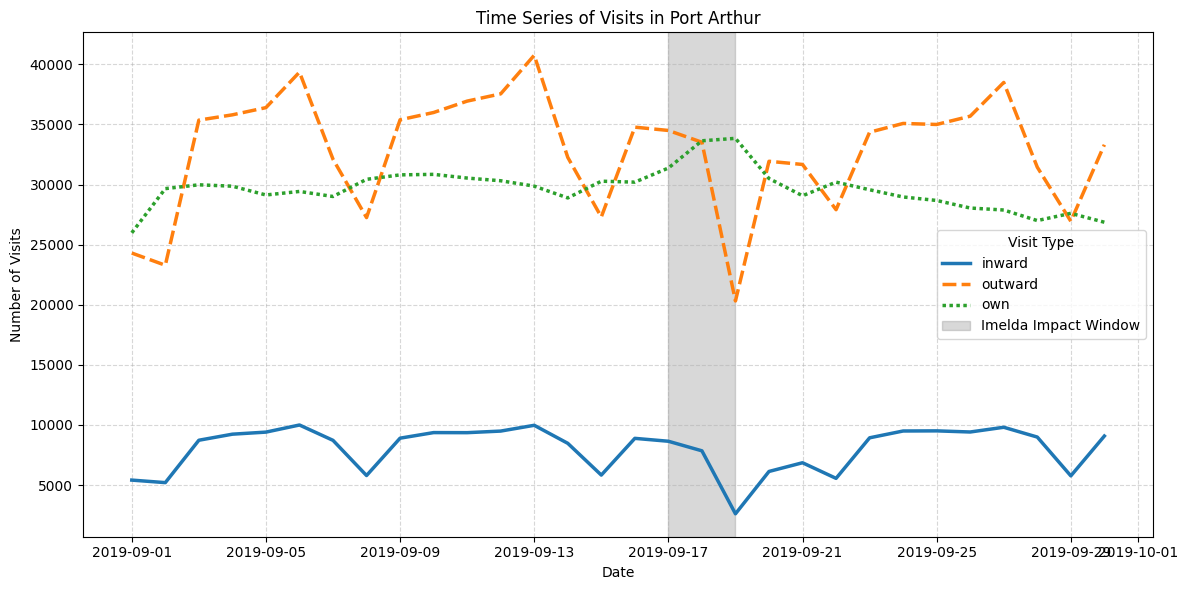

In [15]:
plot_visits(df)

## Disaster 2 Spring Flooding

The dates for spring flooding were not directly availble, hence to find the date window we can find the lowest average mobility accross all the CBGs.

In [16]:
spring_df =  inflow_df[(inflow_df['date'] >= '2019-04-01') & (inflow_df['date'] <= '2019-04-30')]
spring_df

,date,destination_cbg,inflow,smoothed_inflow,normalized_inflow
27736,2019-04-01,481990301001,55,57.666667,0.212766
27737,2019-04-01,481990301002,61,64.000000,0.222222
27738,2019-04-01,481990301003,157,139.333333,0.349398
27739,2019-04-01,481990302001,314,329.000000,0.360704
27740,2019-04-01,481990302002,246,245.333333,0.197351
...,...,...,...,...,...
36975,2019-04-30,483610224001,228,249.000000,0.299301
36976,2019-04-30,483610224002,440,446.666667,0.683394
36977,2019-04-30,483610224003,101,114.000000,0.430939
36978,2019-04-30,483610224004,116,126.333333,0.626263


In [17]:
avg_mobility = spring_df.groupby('date')['smoothed_inflow'].mean().reset_index()

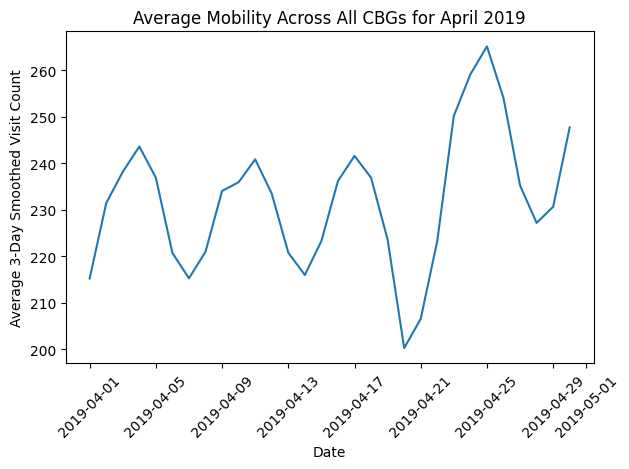

In [18]:
plt.plot(avg_mobility['date'], avg_mobility['smoothed_inflow'])
plt.title("Average Mobility Across All CBGs for April 2019")
plt.xlabel("Date")
plt.ylabel("Average 3-Day Smoothed Visit Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The mobility is minimum after 15th April and recovers after 23rd, hence choosing those days for analysis

In [19]:
import pandas as pd
disaster_start = pd.to_datetime("2019-04-15")
disaster_end = pd.to_datetime("2019-04-23")
baseline_start = pd.to_datetime("2019-04-10")
baseline_end = disaster_start - pd.Timedelta(days=1)
recovery_end = pd.to_datetime("2019-04-30")

In [20]:
analysis_window_df = inflow_df[
    (inflow_df['date'] >= baseline_start) &
    (inflow_df['date'] <= recovery_end)
]

resilience_results = []
cbgs = analysis_window_df['destination_cbg'].unique()

for cbg in cbgs:
    df_cbg = analysis_window_df[analysis_window_df['destination_cbg'] == cbg]
    result = compute_resilience_for_cbg(
        df_cbg,
        baseline_start=baseline_start,
        baseline_end=baseline_end,
        disaster_start=disaster_start,
        recovery_end=recovery_end
    )
    if result:
        resilience_results.append(result)

resilience_df = pd.DataFrame(resilience_results)

In [21]:
top_cbgs = resilience_df.sort_values(by='resilience_ratio', ascending=False).head(3)['cbg'].tolist()
bottom_cbgs = resilience_df.sort_values(by='resilience_ratio', ascending=True).head(3)['cbg'].tolist()

Bottom 3 Least Resilient CBGs


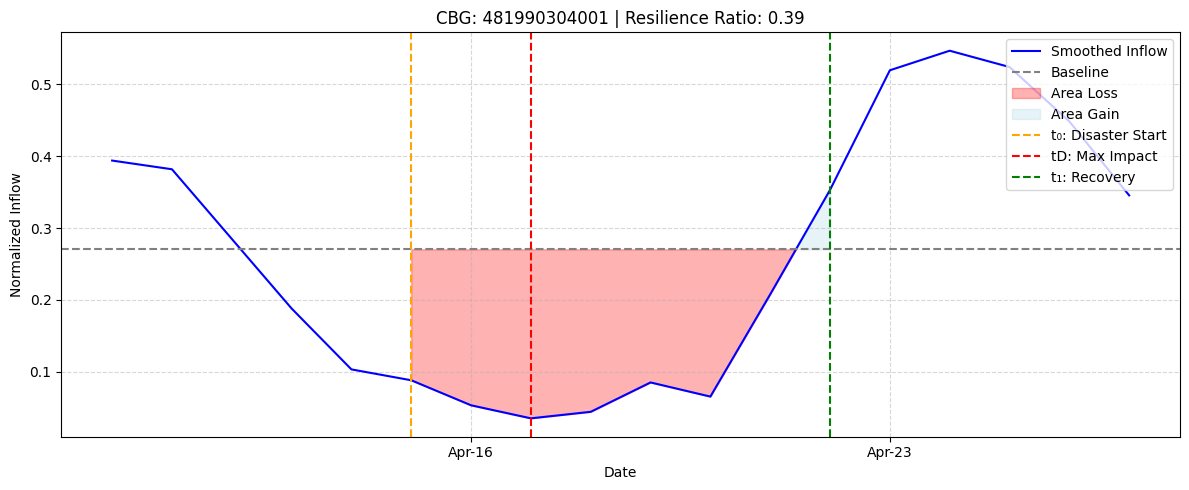

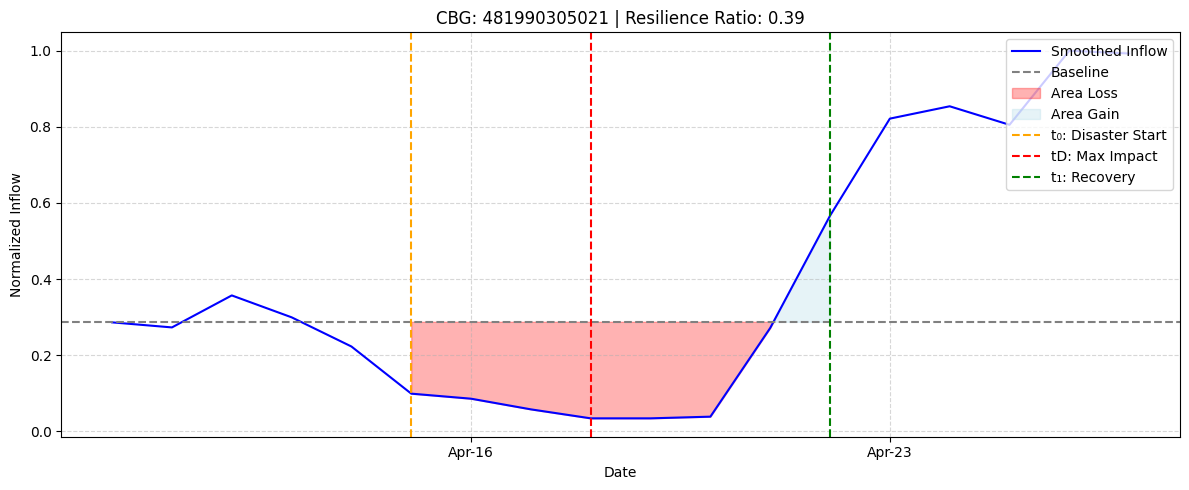

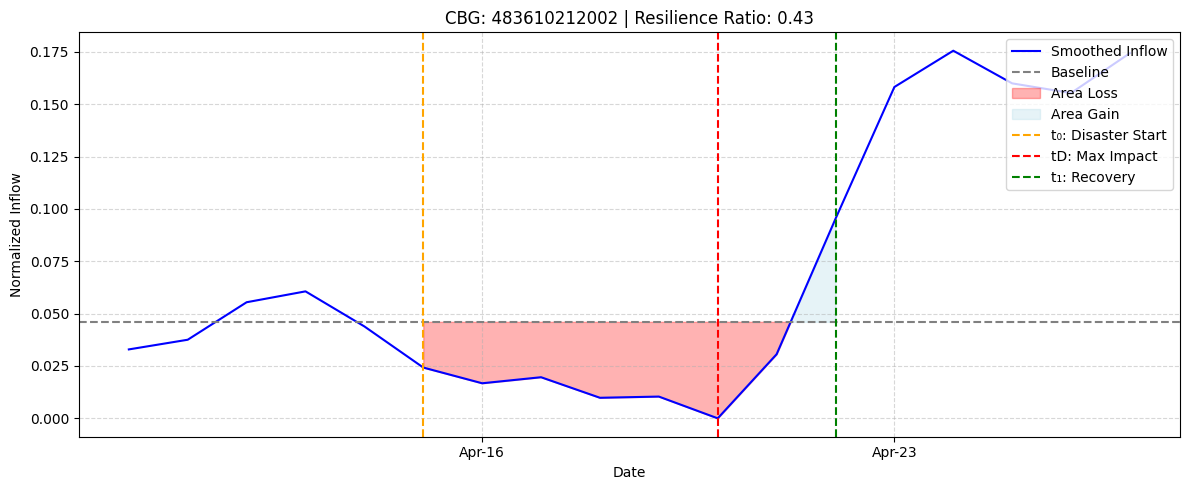

Top 3 Most Resilient CBGs


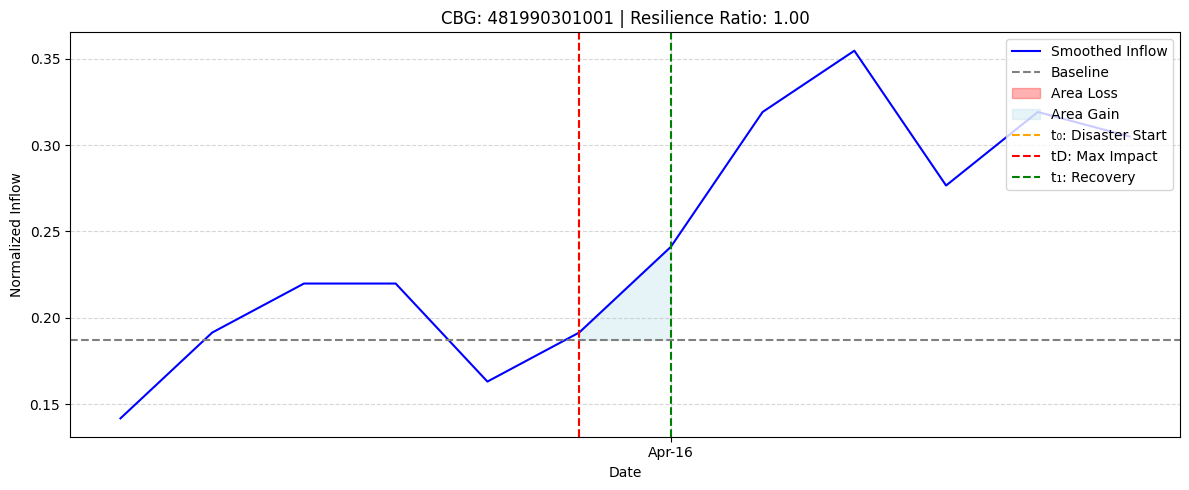

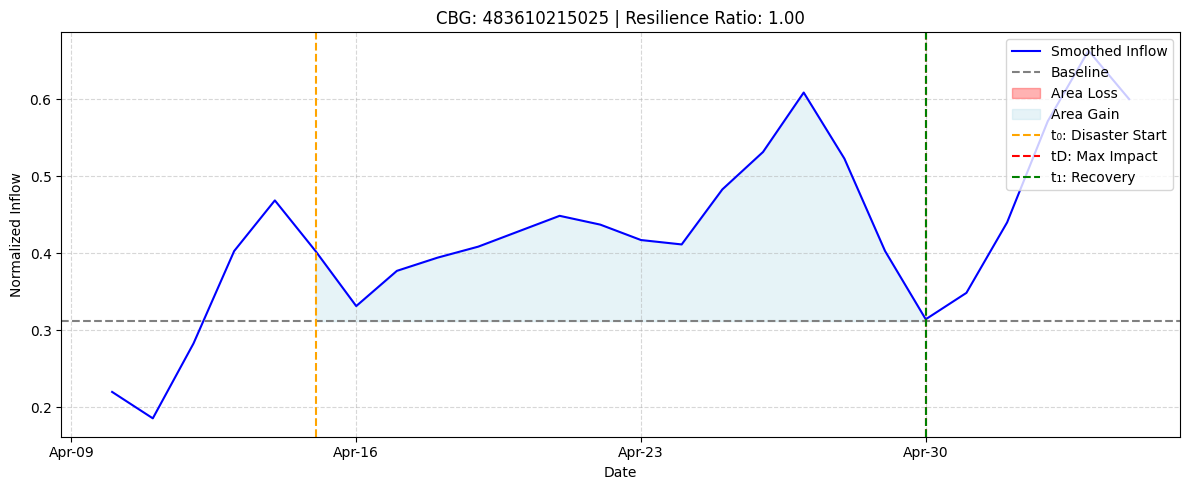

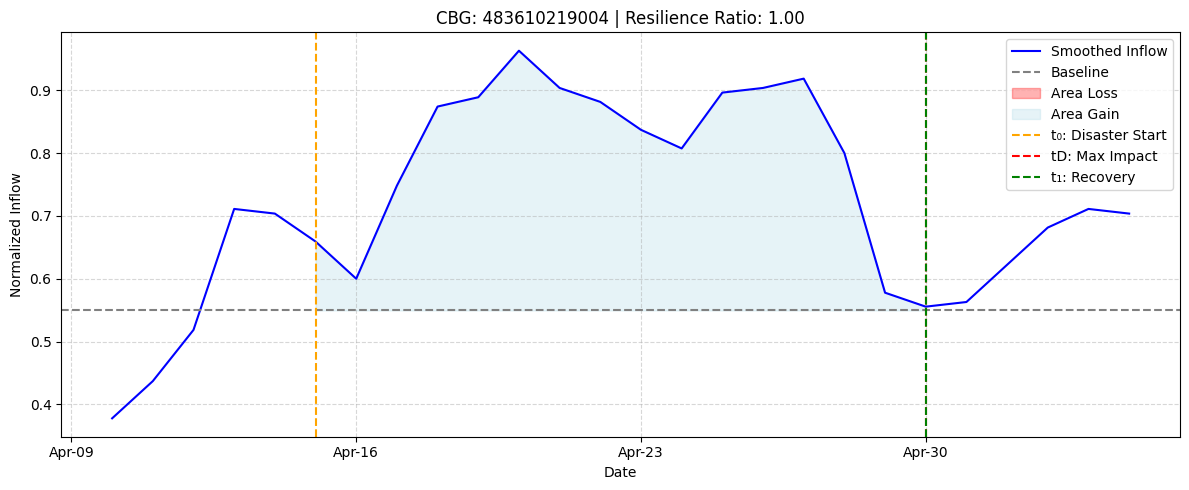

In [22]:
print("Bottom 3 Least Resilient CBGs")
for cbg in bottom_cbgs:
    row = resilience_df[resilience_df['cbg'] == cbg].iloc[0]
    plot_cbg_mobility(cbg, inflow_df, row)


print("Top 3 Most Resilient CBGs")
for cbg in top_cbgs:
    row = resilience_df[resilience_df['cbg'] == cbg].iloc[0]
    plot_cbg_mobility(cbg, inflow_df, row)

C:\Users\shiva\AppData\Local\Temp\ipykernel_9164\697898861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['visit_type'] = df.apply(


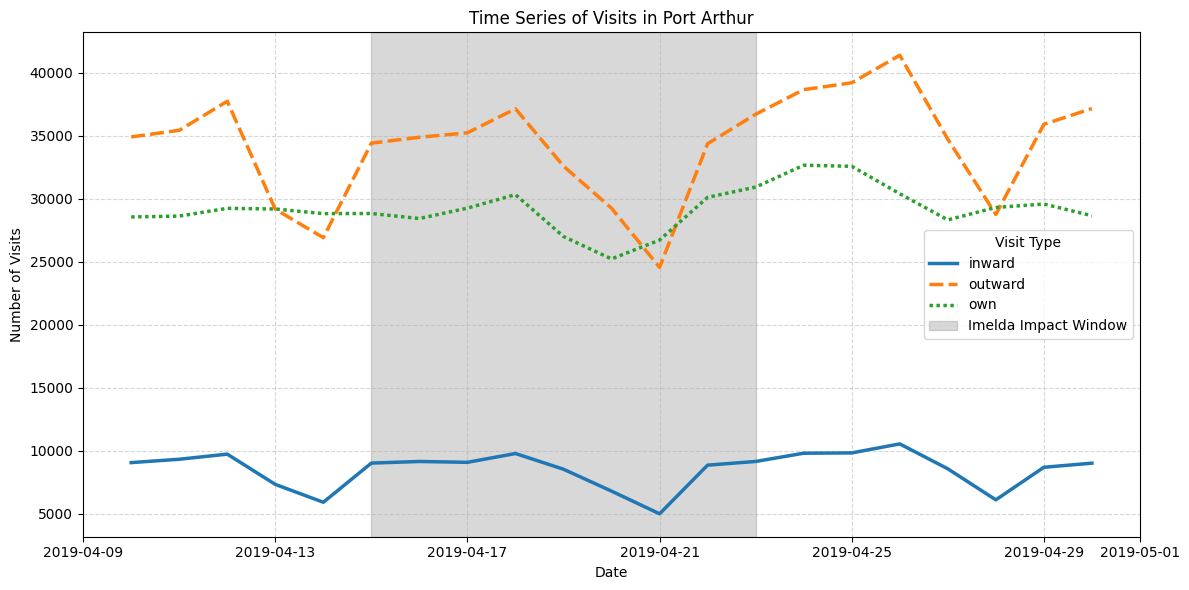

In [23]:
plot_visits(df, start_date='2019-04-10', end_date='2019-04-30', impact_window=('2019-04-15', '2019-04-23'))

## Results

**Normalized Inflow Plot**

* Least Resilient CBGs (Bottom 3): These communities typically show a more pronounced and prolonged drop in mobility (larger orange "Functionality Loss" area) after the disaster, with a slower or incomplete recovery towards the baseline. Their resilience ratios are lower, indicating a greater overall impact on their mobility patterns.


* Most Resilient CBGs (Top 3): In contrast, these CBGs demonstrate relatively stable mobility patterns, or a quicker and more complete recovery to pre-disaster levels. Their plots show minimal "Functionality Loss" (smaller orange areas) and higher resilience ratios, suggesting they were less affected or recovered more effectively during the observed period.

**Visit plot**



*   Inward Visits (solid blue line):
Show noticeable dips during both Imelda Impact Windows, especially during the September 2019 window where visits dropped to a clear low point. This indicates restricted or reduced mobility into Port Arthur during the impact period.

*   Outward Visits (dashed orange line):
Experience sharp declines during the impact periods. The drop is particularly significant in the September 2019 data, suggesting that residents may have reduced travel out of the area due to adverse conditions or disruptions.

*   Own Visits (dotted green line):
These are relatively more stable than inward/outward visits but still exhibit a downward trend during the impact windows.